<a href="https://colab.research.google.com/github/danilsab24/Semantic_Segmentation_Potsdam/blob/main/Semantic_Segmentation_Postdam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import delle librerie

In [ ]:
# Librerie per il Dataset
import torch
import shutil
import random
import numpy as np
from torchvision import transforms
from torchvision.transforms import Compose
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader, ConcatDataset

# Visualizzazione delle immagini
import os
import cv2
import torch.nn as nn
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.image as mpimg
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

# Librerie per test Unet
from sklearn.metrics import recall_score, f1_score, confusion_matrix, classification_report

#GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.1+cu118  Device: cuda


In [ ]:
!git clone https://github.com/danilsab24/Semantic_Segmentation_Potsdam.git

Cloning into 'Semantic_Segmentation_Potsdam'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 133 (delta 73), reused 62 (delta 24), pack-reused 0
Receiving objects: 100% (133/133), 11.02 MiB | 11.97 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [ ]:
from Semantic_Segmentation_Potsdam.Unet import UNET
from Semantic_Segmentation_Potsdam.dataset import MyData

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Definizione variabili globali


In [ ]:
PATCH_SIZE = 250
DATA_MEAN = [0.485, 0.456, 0.406]
DATA_STD = [0.229, 0.224, 0.225]
BATCH_SIZE = 5
SHUFFLE = True
DROP_LAST = True
PIN_MEMORY = True
# Immagini in input sono RGB
IN_CH = 3
# numero di classi che deve predirre
OUT_CH = 6
LEARNING_RATE = 0.001

class_mapping = {
    (255, 255, 255): 0,  # Impervious surfaces
    (0, 0, 255): 1,      # Building
    (0, 255, 255): 2,    # Low vegetation
    (0, 255, 0): 3,      # Tree
    (255, 255, 0): 4,    # Car
    (255, 0, 0): 5       # Clutter/background
}

classes_name = ["Impervious surfaces",
                "Building",
                "Low vegetation",
                "Tree",
                "Car",
                "Clutter/background"]

# Analyze Data - Exploration Data Analysis (EDA)
Dataset è composto da 38 immagini satellitari IRRG di dimensione 6000x6000 e di altre 38 immagini RGB di dimensione 6000x6000 che corrispondono alle immagini satellitari già segmentate in 6 classi:
 1. Impervious surfaces
 2. Building
 3. Low vegetation
 4. Tree
 5. Car
 6. Clutter/background

# Plot immagini dataset

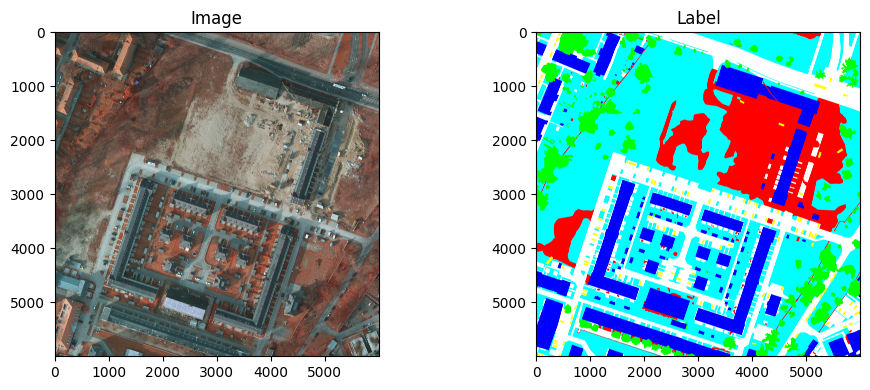

In [ ]:
image_path = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/images_IRRG/top_potsdam_2_10.tif'
label_path = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels/top_potsdam_2_10.tif'

image = mpimg.imread(image_path)
label = mpimg.imread(label_path)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(image)
axs[0].set_title('Image')

axs[1].imshow(label)
axs[1].set_title('Label')

plt.tight_layout()

plt.show()


# Controllo dimensioni
Controllo se tutte le immagini del dataset hanno le stesse dimensioni

In [ ]:
def check_dimensioni(path_1):

  image_filenames = os.listdir(path_1)
  image_size_set = set()

  for image_filename in image_filenames:
      image_path = os.path.join(path_1, image_filename)

      image = Image.open(image_path)

      image_size = image.size

      image_size_set.add(image_size)

  # Controllo dimensioni immagini
  if len(image_size_set) == 1:
      common_image_size = image_size_set.pop()
      print("Tutte le immagini hanno la stessa dimensione:")
      print("Dimensione immagini:", common_image_size)
  else:
      print("Le immagini non hanno tutte la stessa dimensione.")

image_folder = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/images_IRRG'
label_folder = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels'

check_dimensioni(image_folder)
check_dimensioni(label_folder)

Tutte le immagini hanno la stessa dimensione:
Dimensione immagini: (6000, 6000)
Tutte le immagini hanno la stessa dimensione:
Dimensione immagini: (6000, 6000)


# Suddivisione in Patch
Poichè le immagini del dataset sono troppo grandi le suddivido in patch di dimensione 250x250

In [ ]:
original_images_path = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/images_IRRG"
patch_images_save_path = "/content/"
patch_folder_name = "images_patches"


patch_size = PATCH_SIZE

patch_folder_path = os.path.join(patch_images_save_path, patch_folder_name)
if not os.path.exists(patch_folder_path):
    os.mkdir(patch_folder_path)

for image_filename in os.listdir(original_images_path):
  if image_filename.endswith(".tif"):
      image_path = os.path.join(original_images_path, image_filename)

      image = Image.open(image_path)

      num_patches = (image.width // patch_size) * (image.height // patch_size)
      for i in range(0, image.width, patch_size):
          for j in range(0, image.height, patch_size):
              patch = image.crop((i, j, i + patch_size, j + patch_size))
              patch_filename = f"{os.path.splitext(image_filename)[0]}_patch_{i}_{j}.tif"
              patch_save_location = os.path.join(patch_folder_path, patch_filename)

              if not os.path.exists(patch_save_location):
                  patch.save(patch_save_location)

print("Riduzione delle immagini in patch completata.")


Riduzione delle immagini in patch completata.


In [ ]:
original_images_path = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels"
patch_Labels_save_path = "/content/"
patch_folder_name = "labels_patches"

patch_size = PATCH_SIZE

patch_folder_path = os.path.join(patch_Labels_save_path, patch_folder_name)
if not os.path.exists(patch_folder_path):
    os.mkdir(patch_folder_path)

for image_filename in os.listdir(original_images_path):
    if image_filename.endswith(".tif"):
        image_path = os.path.join(original_images_path, image_filename)

        image = Image.open(image_path)

        num_patches = (image.width // patch_size) * (image.height // patch_size)
        for i in range(0, image.width, patch_size):
            for j in range(0, image.height, patch_size):
                patch = image.crop((i, j, i + patch_size, j + patch_size))
                patch_filename = f"{os.path.splitext(image_filename)[0]}_patch_{i}_{j}.tif"   # Genera un nome univoco per ogni patch
                patch_save_location = os.path.join(patch_folder_path, patch_filename)

                if not os.path.exists(patch_save_location):
                    patch.save(patch_save_location)

print("Riduzione delle immagini in patch completata.")

Riduzione delle immagini in patch completata.


# Controllo numero immagini
Essendoci nel dataset originale 38 immagini IRRG di dimensione 6000x6000 e 38 immagini RGB di dimensione 6000x6000, ci drovanno essere in ogni cartella: \
$ [(6000\cdot6000)/(250\cdot250)]\cdot38 = 21888 $ immagini

In [ ]:
def check_num_element(path):
  image_count = 0

  for filename in os.listdir(path):
      if filename.endswith(".tif"):
          image_count += 1
  return image_count

patch_folder_path_images = "/content/images_patches"
num = check_num_element(patch_folder_path_images)
print(f"Numero totale di immagini nella cartella images_patches: {num}")

patch_folder_path_label = "/content/labels_patches"
num = check_num_element(patch_folder_path_images)
print(f"Numero totale di immagini nella cartella labels_patches: {num}")

Numero totale di immagini nella cartella images_patches: 21888
Numero totale di immagini nella cartella labels_patches: 21888


# Controllo dimensioni delle patch

In [ ]:
image_folder = '/content/images_patches'
label_folder = '/content/labels_patches'

image_filenames = os.listdir(image_folder)
label_filenames = os.listdir(label_folder)

image_size_set = set()
label_size_set = set()

for image_filename, label_filename in zip(image_filenames, label_filenames):
    image_path = os.path.join(image_folder, image_filename)
    label_path = os.path.join(label_folder, label_filename)

    image = Image.open(image_path)
    label = Image.open(label_path)

    image_size = image.size
    label_size = label.size

    image_size_set.add(image_size)
    label_size_set.add(label_size)

# Controlla se tutte le immagini hanno le stesse dimensioni
if len(image_size_set) == 1 and len(label_size_set) == 1:
    common_image_size = image_size_set.pop()
    common_label_size = label_size_set.pop()
    print("Tutte le immagini hanno la stessa dimensione:")
    print("Dimensione immagini:", common_image_size)
    print("Dimensione etichette:", common_label_size)
else:
    print("Le immagini non hanno tutte la stessa dimensione.")

Tutte le immagini hanno la stessa dimensione:
Dimensione immagini: (250, 250)
Dimensione etichette: (250, 250)


# Plot delle patch

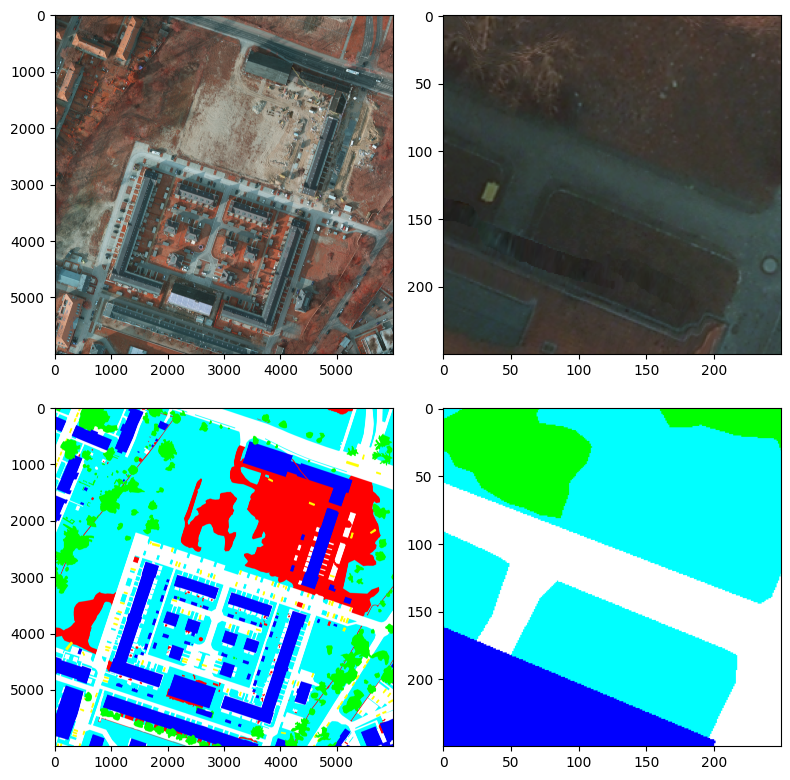

In [ ]:
image_paths = [
    "/content/drive/MyDrive/Semantic_Segmentation_Postdam/images_IRRG/top_potsdam_2_10.tif",
    "/content/images_patches/top_potsdam_2_10_patch_0_0.tif",
    "/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels/top_potsdam_2_10.tif",
    "/content/labels_patches/top_potsdam_2_10_patch_0_0.tif"
]

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for i, ax in enumerate(axs.flat):
    img = mpimg.imread(image_paths[i])
    ax.imshow(img)
    ax.axis('on')

plt.tight_layout()
plt.show()


# Mapping delle label
Le immagini segmentate sono in formato RGB ma ad ogni colore corrisponde una classe :
 *   (255, 255, 255)(Colore: Bianco)   Impervious surfaces
 *   (0, 0, 255)     (Colore: Blu)     Building
 *   (0, 255, 255)    (Colore: Ciano)  Low vegetation
 *   (0, 255, 0)      (Colore: Verde)  Tree
 *   (255, 255, 0)   (Colore: Giallo)  Car
 *   (255, 0, 0)     (Colore: Rosso)   Clutter/background

In [ ]:
input_folder = '/content/labels_patches'
output_folder = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/label_patch_converted'

os.makedirs(output_folder, exist_ok=True)

file_list = [filename for filename in os.listdir(input_folder) if filename.endswith('.tif')]
total_images = len(file_list)
converted_images = 0

print("Total images to convert:", total_images)

for filename in file_list:
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)

    input_image = Image.open(input_path)
    output_image = Image.new('L', input_image.size)

    for y in range(input_image.height):
        for x in range(input_image.width):
            pixel_value = input_image.getpixel((x, y))[:3]

            if pixel_value in class_mapping:
                output_image.putpixel((x, y), class_mapping[pixel_value])
    converted_images += 1
    #print("Converted: ",converted_images)
    output_image.save(output_path)
print("\nConversione completata.")



Conversione completata.


In [ ]:
input_folder = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels'
output_folder = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels_converted'

os.makedirs(output_folder, exist_ok=True)

file_list = [filename for filename in os.listdir(input_folder) if filename.endswith('.tif')]
total_images = len(file_list)
converted_images = 0

print("Total images to convert:", total_images)

for filename in file_list:
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)

    input_image = Image.open(input_path)
    output_image = Image.new('L', input_image.size)

    for y in range(input_image.height):
        for x in range(input_image.width):
            pixel_value = input_image.getpixel((x, y))[:3]

            if pixel_value in class_mapping:
                output_image.putpixel((x, y), class_mapping[pixel_value])
    converted_images += 1
    #print("Converted: ",converted_images)
    output_image.save(output_path)
print("\nConversione completata.")



Conversione completata.


In [ ]:
patch_folder_path_label_converted = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/label_patch_converted"
num = check_num_element(patch_folder_path_label_converted)
print(f"Numero totale di immagini nella cartella label_converted: {num}")

patch_folder_path_label_converted = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels_converted"
num = check_num_element(patch_folder_path_label_converted)
print(f"Numero totale di immagini nella cartella label_converted (label originali convertite): {num}")

Numero totale di immagini nella cartella label_converted: 21888
Numero totale di immagini nella cartella label_converted (label originali convertite): 38


# Controllo dimensioni delle label convertite

In [ ]:
check_dimensioni("/content/drive/MyDrive/Semantic_Segmentation_Postdam/label_patch_converted")
check_dimensioni("/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels_converted")

Tutte le immagini hanno la stessa dimensione:
Dimensione immagini: (250, 250)
Tutte le immagini hanno la stessa dimensione:
Dimensione immagini: (6000, 6000)


# Plot del mapping

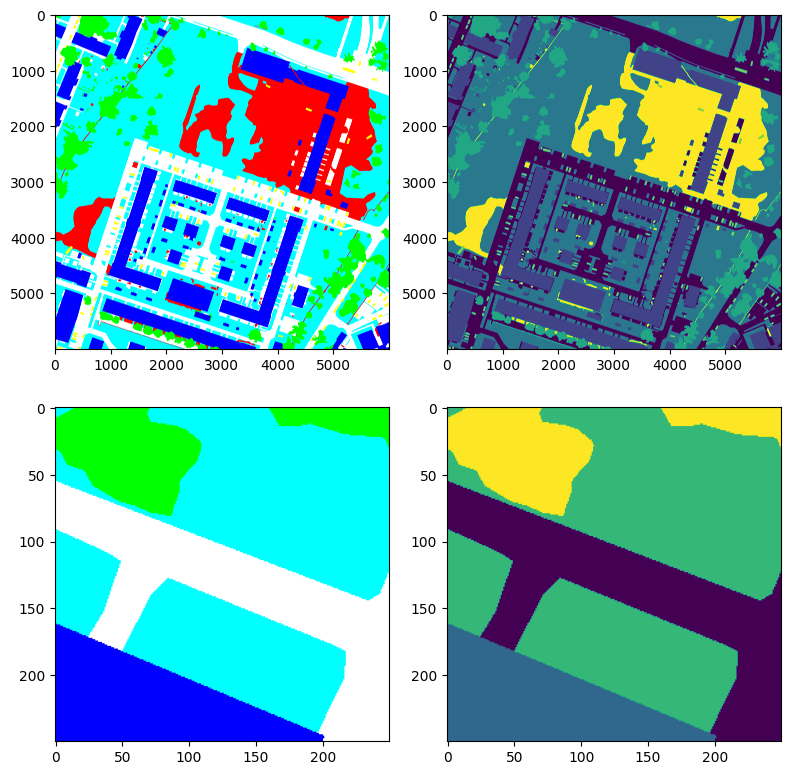

In [ ]:
image_paths = [
    "/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels/top_potsdam_2_10.tif",
    "/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels_converted/top_potsdam_2_10.tif",
    "/content/labels_patches/top_potsdam_2_10_patch_0_0.tif",
    "/content/drive/MyDrive/Semantic_Segmentation_Postdam/label_patch_converted/top_potsdam_2_10_label_patch_0_0.tif"
]

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for i, ax in enumerate(axs.flat):
    img = mpimg.imread(image_paths[i])
    ax.imshow(img)
    ax.axis('on')

plt.tight_layout()
plt.show()

# Copia  in colab
Copia della cartella con le patch delle label convertite da google drive su colab

In [ ]:
source_folder = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/label_patch_converted'
destination_folder = '/content/labels_patch_converted'

os.makedirs(destination_folder, exist_ok=True)

file_list = [filename for filename in os.listdir(source_folder) if filename.endswith('.tif')]
total_images = len(file_list)

num_copy = 0

for filename in os.listdir(source_folder):
    source_path = os.path.join(source_folder, filename)
    destination_path = os.path.join(destination_folder, filename)

    shutil.copy(source_path, destination_path)
    num_copy += 1
    #print("Copy Image: ",num_copy," / ",total_images)

print("Copia completata.")

Copia completata.


In [ ]:
patch_folder_path_label_converted = "/content/labels_patch_converted"
num = check_num_element(patch_folder_path_label_converted)
print(f"Numero totale di immagini nella cartella label_converted (posizione Colab): {num}")

Numero totale di immagini nella cartella label_converted (posizione Colab): 21888


In [ ]:
check_dimensioni("/content/labels_patch_converted")

Tutte le immagini hanno la stessa dimensione:
Dimensione immagini: (250, 250)


# Rinominazione delle immagini
Per fare in modo che ci sia una corrispondenza tra immagine non segmentate e label rinomino tutte le immagini

In [ ]:
def rename_files_in_folder(folder_path, old_substring, new_substring):
    for filename in os.listdir(folder_path):
        if old_substring in filename:
            new_filename = filename.replace(old_substring, new_substring)
            old_file_path = os.path.join(folder_path, filename)
            new_file_path = os.path.join(folder_path, new_filename)
            os.rename(old_file_path, new_file_path)
            #print(f"File rinominato: {filename} -> {new_filename}")

data_folder = "/content/images_patches"
rename_files_in_folder(data_folder, "_IRRG", "")

target_folder = "/content/labels_patches"
rename_files_in_folder(target_folder, "_label", "")

target_folder = "/content/labels_patch_converted"
rename_files_in_folder(target_folder, "_label", "")

data_folder = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/images_IRRG"
rename_files_in_folder(data_folder, "_IRRG", "")

target_folder = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels"
rename_files_in_folder(target_folder, "_label", "")

print("Rinominazione completata.")

Rinominazione completata.


# Creazione Train set, Validation set e Test set
Per la creazione del dataset verrano usate le patch delle immagini non segmentate di dimensione 250x250 e le patch delle labels mappate di dimensione 250x250

# Data Augmentation
Effettuo data Augmentation delle immagini al fine di migliorare la robustezza del modello, ridurre l'overfitting ed aumentare la variabilità dei dati

In [ ]:
# Flip orizzontale dell'immagine
class HorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return np.flip(img, axis=1).copy()
        return img
# Normalizzazione dell'immagine
class Normalize:
    def __init__(self, mean, std):
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, img):
        img = (img - self.mean) / self.std
        return img
# Rotazione dell'immagine
class Rotate:
    def __init__(self, angle_range):
        self.angle_range = angle_range

    def __call__(self, img):
        angle = random.uniform(self.angle_range[0], self.angle_range[1])
        return np.array(Image.fromarray(img).rotate(angle))

# Sfocatura Gaussiana dell'immagine
class GaussianBlur:
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size

    def __call__(self, img):
        return cv2.GaussianBlur(img, (self.kernel_size, self.kernel_size), 0)

# Scalatura dell'immagine
class Scale:
    def __init__(self, scale_range=(0.8, 1.2)):
        self.scale_range = scale_range

    def __call__(self, img):
        scale_factor = random.uniform(self.scale_range[0], self.scale_range[1])
        return cv2.resize(img, None, fx=scale_factor, fy=scale_factor)

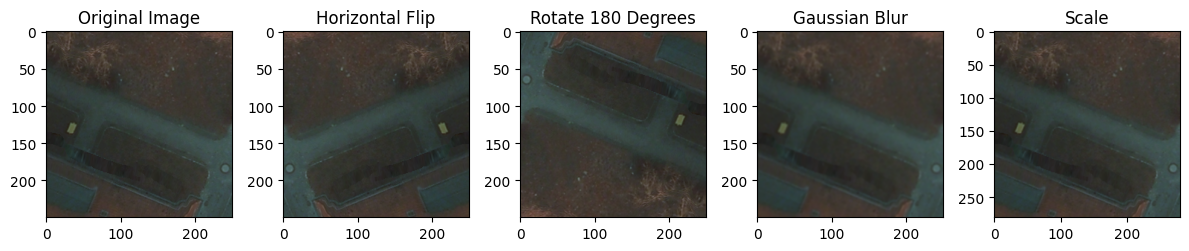

In [ ]:
image_path = "/content/images_patches/top_potsdam_2_10_patch_0_0.tif"

original_image = np.array(Image.open(image_path))

augmentations = [
    (HorizontalFlip(p=1.0), "Horizontal Flip"),
    (Rotate(angle_range=(180, 180)), "Rotate 180 Degrees"),
    (GaussianBlur(kernel_size=5), "Gaussian Blur"),
    (Scale(scale_range=(0.8, 1.2)), "Scale"),
]

# Immagine originale
plt.figure(figsize=(12, 6))
plt.subplot(1, len(augmentations) + 1, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('on')

for i, (augmentation, title) in enumerate(augmentations, start=1):
    transformed_image = augmentation(original_image.copy())

    plt.subplot(1, len(augmentations) + 1, i + 1)
    plt.title(title)
    plt.imshow(transformed_image)
    plt.axis('on')

plt.tight_layout()
plt.show()

# Unet
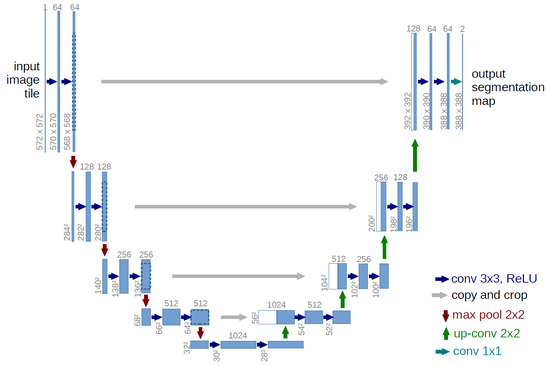
\
Per effettuare la segmentazione dell'immagini utilizzo un modello di Rete Neurale Unet, così strutturato:

*   **Downsampling**: Composto da strati di convolutional layer e BatchNormalize. Utilizza Max Pooling per ridurre progressivamente le dimensioni dell'immagine, consentendo al modello di acquisire informazioni su diverse scale.
Incorpora strati "DoubleCovolution" che combinano convoluzioni, normalizzazione batch e attivazioni ReLU per apprendere rappresentazioni complesse.
*   **Upsampling**: utilizza strati di convoluzione trasposta (ConvTranspose2d) per aumentare gradualmente le dimensioni dell'immagine. Presenta strati "DoubleCovolution" che contribuiscono a conservare e ampliare le informazioni di contesto.
*   **Bottleneck**: uno strato "DoubleCovolution" agisce come un "bottleneck", imparando rappresentazioni complesse delle caratteristiche dell'immagine.
*   **Final Convolution**: alla fine dell' Upsampling, c'è un singolo strato di convoluzione con un kernel di dimensione (1, 1). Questo strato "di riduzione" riduce il numero di canali delle caratteristiche a sei, che rappresentano le classi di segmentazione finali.
*   **BatchNormalization** **e** **ReLU**: La BatchNormalization è utilizzata in vari strati per migliorare la stabilità dell'addestramento. Le attivazioni ReLU (Rectified Linear Unit) introdotte dopo ogni convoluzione aggiungono la non linearità all'architettura.



# Modello 0
Modello 0 utilizza un modello di rete neurale Unet addestrato con un dataset a cui è stato applicato DataAugmentation e utilizzando:
* Loss function: Cross Entropy Loss
* Otimmizzatore: SGD

In [ ]:
def dataset(path_1, path_2, train_transform, test_transform):
  # Creazione del dataset
  dataset = MyData(path_1, path_2, transform=transforms.ToTensor())

  # Divisione dei dati in train, validation e test set
  val_split = 0.1
  test_split = 0.1
  dataset_size = len(dataset)
  val_size = int(val_split * dataset_size)
  test_size = int(test_split * dataset_size)
  train_size = dataset_size - val_size - test_size

  train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
  val_train_set, val_test_set = random_split(val_dataset, [0.5, 0.5])

  # Applica le trasformazioni al trainset e al testset
  train_dataset.transform = train_transform
  val_train_set.transform = test_transform
  val_test_set.transform = test_transform
  test_dataset.transform = test_transform

  # Creazione dei DataLoader
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE, drop_last=DROP_LAST, pin_memory=PIN_MEMORY)
  val_train_loader = DataLoader(val_train_set, batch_size=BATCH_SIZE)
  val_test_loader = DataLoader(val_test_set, batch_size=BATCH_SIZE)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
  return dataset, train_dataset, val_train_set, val_test_set, test_dataset, train_loader, val_train_loader, val_test_loader, test_loader

In [ ]:
train_transform = Compose([
    HorizontalFlip(p=1.0),
    Rotate(angle_range=(180, 180)),
    GaussianBlur(kernel_size=5),
    Scale(scale_range=(0.8, 1.2)),
    Normalize(mean = DATA_MEAN, std = DATA_STD),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    Normalize(mean = DATA_MEAN, std = DATA_STD),
    transforms.ToTensor()
])

In [ ]:
patch_Images_save_path = "/content/images_patches"
patch_Labels_save_path = "/content/labels_patch_converted"
tr_transform = train_transform
ts_transform = test_transform
dataset, train_dataset, val_train_set, val_test_set, test_dataset, train_loader, val_train_loader, val_test_loader, test_loader = dataset(patch_Images_save_path, patch_Labels_save_path, tr_transform, ts_transform)

print(f"Dataset size: {len(dataset)} samples")
print(f"Train dataset size: {len(train_dataset)} samples")
print(f"Validation_train dataset size: {len(val_train_set)} samples")
print(f"Validation_train dataset size: {len(val_test_set)} samples")
print(f"Test dataset size: {len(test_dataset)} samples")

Dataset size: 21888 samples
Train dataset size: 17512 samples
Validation_train dataset size: 1094 samples
Validation_train dataset size: 1094 samples
Test dataset size: 2188 samples


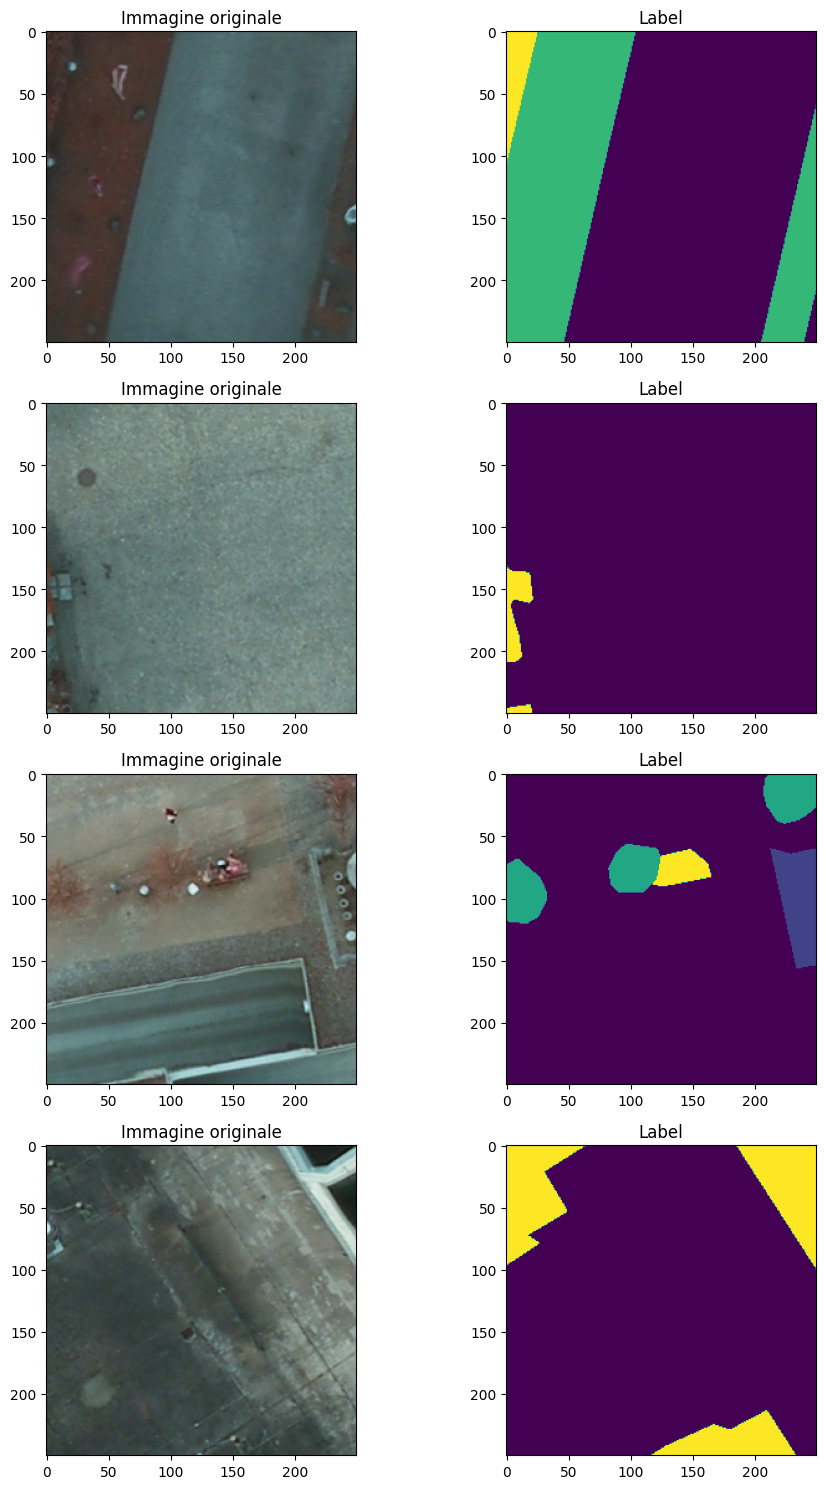

In [ ]:
dataiter = iter(train_loader)
data_batch, target_batch = next(dataiter)

data_batch = data_batch[:4]
target_batch = target_batch[:4]

fig, axes = plt.subplots(4, 2, figsize=(10, 15))

for i in range(4):
    data_img = np.transpose(data_batch[i], (1, 2, 0))
    target_img = np.transpose(target_batch[i].numpy(), (1, 2, 0))

    axes[i, 0].imshow(data_img)
    axes[i, 0].set_title("Immagine originale")
    axes[i, 0].axis('on')

    axes[i, 1].imshow(target_img)
    axes[i, 1].set_title("Label")
    axes[i, 1].axis('on')

plt.tight_layout()
plt.show()

In [ ]:
model = UNET(IN_CH, OUT_CH).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
print(model)

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleCovolution(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleCovolution(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stri

In [ ]:
def train(epoch, train_loader, log_interval=1000):

    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):

      data = data.to(device)
      target = target.squeeze(1).to(device)

      output = model(data)
      LogSoftmax = nn.LogSoftmax(dim=1)
      output = LogSoftmax(output)

      loss = criterion(output, target.long())

      optimizer.zero_grad()

      # Backpropagate
      loss.backward()

      optimizer.step()

      running_loss += loss.item()
      if batch_idx % log_interval == 0:

          running_loss = 0.0
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.data.item()))

In [ ]:
def validate(loss_vector, accuracy_vector, val_loader):
    model.eval()
    val_loss, correct = 0, 0
    num_pixels = 0
    for data, target in val_loader:

        data = data.to(device)
        target = target.squeeze(1).to(device)

        with torch.no_grad():
          output = model(data)

          LogSoftmax = nn.LogSoftmax(dim=1)
          output = LogSoftmax(output)

          pred = torch.argmax(output, axis=1)
          loss = criterion(output, target.long())
          val_loss += loss.item()

          correct += (pred == target).sum()
          num_pixels += torch.numel(pred)

    val_loss /= len(val_loader)
    accuracy = 100.0 * correct / num_pixels


    loss_vector.append(val_loss)
    accuracy_vector.append(accuracy)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, num_pixels, accuracy))

In [ ]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch, train_loader)
    validate(lossv, accv, val_train_loader)

Train Epoch: 1 [0/17512 (0%)]	Loss: 1.929473
Train Epoch: 1 [5000/17512 (29%)]	Loss: 1.233520
Train Epoch: 1 [10000/17512 (57%)]	Loss: 0.981986
Train Epoch: 1 [15000/17512 (86%)]	Loss: 1.109491

Validation set: Average loss: 1.0600, Accuracy: 40217038/68375000 (59%)

Train Epoch: 2 [0/17512 (0%)]	Loss: 1.124849
Train Epoch: 2 [5000/17512 (29%)]	Loss: 0.980021
Train Epoch: 2 [10000/17512 (57%)]	Loss: 1.002241
Train Epoch: 2 [15000/17512 (86%)]	Loss: 0.797992

Validation set: Average loss: 1.0032, Accuracy: 41604413/68375000 (61%)

Train Epoch: 3 [0/17512 (0%)]	Loss: 1.081123
Train Epoch: 3 [5000/17512 (29%)]	Loss: 0.877222
Train Epoch: 3 [10000/17512 (57%)]	Loss: 0.798726
Train Epoch: 3 [15000/17512 (86%)]	Loss: 1.102397

Validation set: Average loss: 0.9453, Accuracy: 43767718/68375000 (64%)

Train Epoch: 4 [0/17512 (0%)]	Loss: 0.844073
Train Epoch: 4 [5000/17512 (29%)]	Loss: 0.692276
Train Epoch: 4 [10000/17512 (57%)]	Loss: 1.068627
Train Epoch: 4 [15000/17512 (86%)]	Loss: 0.989066

V

# State Model save

In [ ]:
model_path = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/model0_state_save.pth'

os.makedirs(os.path.dirname(model_path), exist_ok=True)

torch.save({
    "accv": accv,
    "lossv": lossv,
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'criterion_state_dict': criterion.state_dict(),
}, model_path)

# Test modello 0

Test set: Accuracy: 52319461/68375000 (76.52%)


Mean Intersection over Union (mIoU) for each class:
[0.6651737  0.72883986 0.58356353 0.54572247 0.61319805 0.09540927]
Classification report for MLP:
                     precision    recall  f1-score   support

Impervious surfaces       0.81      0.79      0.80  21854077
           Building       0.84      0.85      0.84  17338409
     Low vegetation       0.66      0.84      0.74  14613230
               Tree       0.76      0.66      0.71  10432116
                Car       0.79      0.74      0.76   1237330
 Clutter/background       0.48      0.11      0.17   2899838

           accuracy                           0.77  68375000
          macro avg       0.72      0.66      0.67  68375000
       weighted avg       0.76      0.77      0.76  68375000



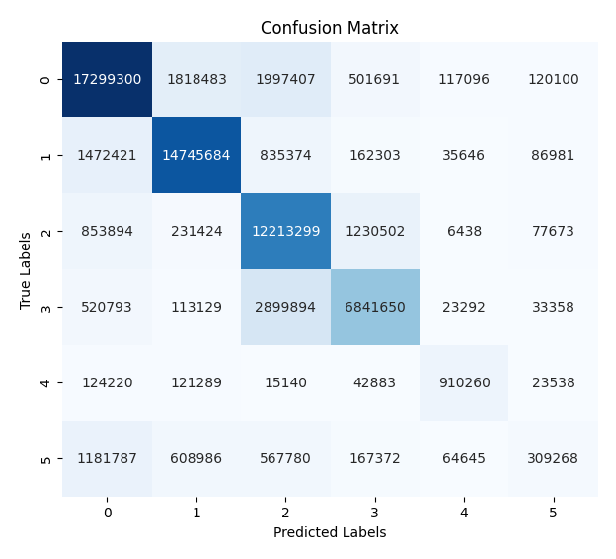

In [ ]:
def compute_mIoU(confusion_matrix):
    intersection = np.diag(confusion_matrix)
    union = np.sum(confusion_matrix, axis=1) + np.sum(confusion_matrix, axis=0) - intersection
    mIoU = intersection / np.maximum(1, union)
    return mIoU

def test():
    model.eval()
    correct = 0
    num_pixels = 0
    predicted_labels = []
    true_labels = []

    for data, target in val_test_loader:
        data = data.to(device)
        target = target.squeeze(1).to(device)

        output = model(data)
        LogSoftmax = nn.LogSoftmax(dim=1)
        output = LogSoftmax(output)

        pred = torch.argmax(output, axis=1)
        correct += (pred == target).sum()
        num_pixels += torch.numel(pred)

        predicted_labels.extend(pred.cpu().numpy())
        true_labels.extend(target.cpu().numpy())

    accuracy = 100.0 * correct / num_pixels
    print('\nTest set: Accuracy: {}/{} ({:.2f}%)\n'.format(
        correct, num_pixels, accuracy))


    return predicted_labels, true_labels

checkpoint = torch.load('/content/drive/MyDrive/Semantic_Segmentation_Postdam/model0_state_save.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion.load_state_dict(checkpoint['criterion_state_dict'])
epoch = checkpoint['epoch']

predicted_labels, true_labels = test()

predicted_labels = np.array(predicted_labels).flatten()
true_labels = np.array(true_labels).flatten()


# confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

mIoU_scores = compute_mIoU(confusion_mat)
print("\nMean Intersection over Union (mIoU) for each class:")
print(mIoU_scores)

# Print del classification report
print("Classification report for MLP:\n%s\n"
      % (classification_report(true_labels, predicted_labels, target_names=classes_name)))

plt.figure(figsize=(7, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# 1 Modello
Modello 1 utilizza come rete neurale lo stesso modello utilizzato da Modello 0 e lo stesso Dataset con DataAugmentation
* Loss Function: Cross Entropy Loss
* Ottimizzatore: Adam

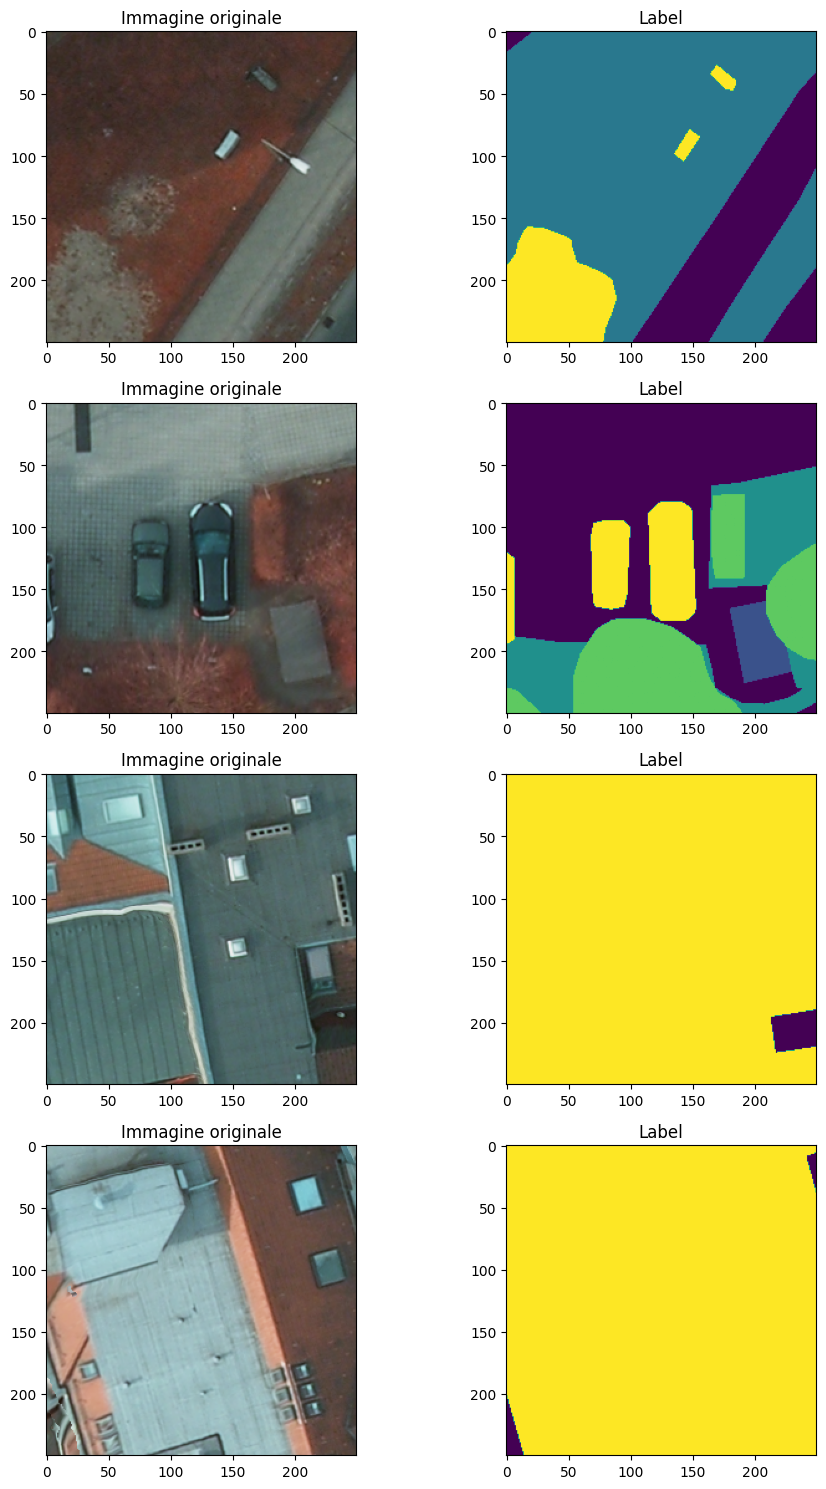

In [ ]:
dataiter = iter(train_loader)
data_batch, target_batch = next(dataiter)

data_batch = data_batch[:4]
target_batch = target_batch[:4]

fig, axes = plt.subplots(4, 2, figsize=(10, 15))

for i in range(4):
    data_img = np.transpose(data_batch[i], (1, 2, 0))
    target_img = np.transpose(target_batch[i].numpy(), (1, 2, 0))

    axes[i, 0].imshow(data_img)
    axes[i, 0].set_title("Immagine originale")
    axes[i, 0].axis('on')

    axes[i, 1].imshow(target_img)
    axes[i, 1].set_title("Label")
    axes[i, 1].axis('on')

plt.tight_layout()
plt.show()

In [ ]:
model = UNET(IN_CH, OUT_CH).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
print(model)

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleCovolution(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleCovolution(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stri

In [ ]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch, train_loader)
    validate(lossv, accv, val_train_loader)

Train Epoch: 1 [0/17512 (0%)]	Loss: 1.136530
Train Epoch: 1 [5000/17512 (29%)]	Loss: 1.316109
Train Epoch: 1 [10000/17512 (57%)]	Loss: 1.030965
Train Epoch: 1 [15000/17512 (86%)]	Loss: 1.637949

Validation set: Average loss: 0.9857, Accuracy: 41462495/68375000 (61%)

Train Epoch: 2 [0/17512 (0%)]	Loss: 0.991521
Train Epoch: 2 [5000/17512 (29%)]	Loss: 1.110513
Train Epoch: 2 [10000/17512 (57%)]	Loss: 0.896444
Train Epoch: 2 [15000/17512 (86%)]	Loss: 0.949828

Validation set: Average loss: 0.9286, Accuracy: 44181518/68375000 (65%)

Train Epoch: 3 [0/17512 (0%)]	Loss: 0.954061
Train Epoch: 3 [5000/17512 (29%)]	Loss: 0.793963
Train Epoch: 3 [10000/17512 (57%)]	Loss: 0.762478
Train Epoch: 3 [15000/17512 (86%)]	Loss: 0.609607

Validation set: Average loss: 0.8467, Accuracy: 47479161/68375000 (69%)

Train Epoch: 4 [0/17512 (0%)]	Loss: 0.661571
Train Epoch: 4 [5000/17512 (29%)]	Loss: 0.713408
Train Epoch: 4 [10000/17512 (57%)]	Loss: 0.811136
Train Epoch: 4 [15000/17512 (86%)]	Loss: 0.696335

V

In [ ]:
model_path = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/model1_state_save.pth'

os.makedirs(os.path.dirname(model_path), exist_ok=True)

torch.save({
    "accv": accv,
    "lossv": lossv,
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'criterion_state_dict': criterion.state_dict(),
}, model_path)


Test set: Accuracy: 53459680/68375000 (78.19%)


Mean Intersection over Union (mIoU) for each class:
[0.66480177 0.72951966 0.61474416 0.62894836 0.67758706 0.15455429]
Classification report for MLP:
                     precision    recall  f1-score   support

Impervious surfaces       0.78      0.81      0.80  21854077
           Building       0.87      0.82      0.84  17338409
     Low vegetation       0.70      0.84      0.76  14613230
               Tree       0.82      0.73      0.77  10432116
                Car       0.81      0.81      0.81   1237330
 Clutter/background       0.49      0.18      0.27   2899838

           accuracy                           0.78  68375000
          macro avg       0.74      0.70      0.71  68375000
       weighted avg       0.78      0.78      0.78  68375000




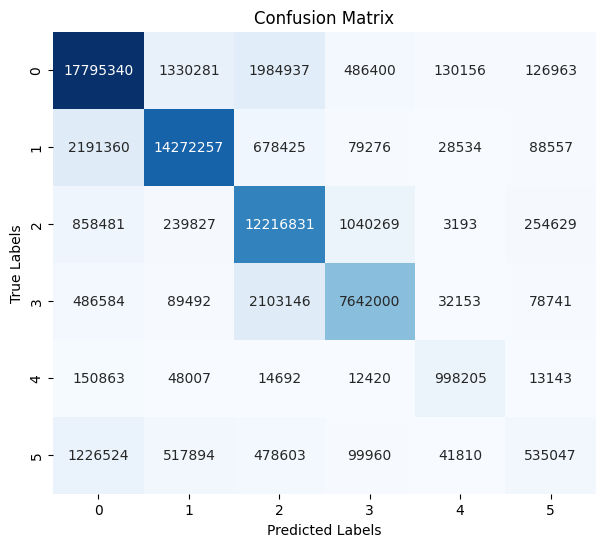

In [ ]:
def compute_mIoU(confusion_matrix):
    intersection = np.diag(confusion_matrix)
    union = np.sum(confusion_matrix, axis=1) + np.sum(confusion_matrix, axis=0) - intersection
    mIoU = intersection / np.maximum(1, union)
    return mIoU

def test():
    model.eval()
    correct = 0
    num_pixels = 0
    predicted_labels = []
    true_labels = []

    for data, target in val_test_loader:
        data = data.to(device)
        target = target.squeeze(1).to(device)

        output = model(data)
        LogSoftmax = nn.LogSoftmax(dim=1)
        output = LogSoftmax(output)

        pred = torch.argmax(output, axis=1)
        correct += (pred == target).sum()
        num_pixels += torch.numel(pred)

        predicted_labels.extend(pred.cpu().numpy())
        true_labels.extend(target.cpu().numpy())

    accuracy = 100.0 * correct / num_pixels
    print('\nTest set: Accuracy: {}/{} ({:.2f}%)\n'.format(
        correct, num_pixels, accuracy))


    return predicted_labels, true_labels

checkpoint = torch.load('/content/drive/MyDrive/Semantic_Segmentation_Postdam/model1_state_save.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion.load_state_dict(checkpoint['criterion_state_dict'])
epoch = checkpoint['epoch']

predicted_labels, true_labels = test()

predicted_labels = np.array(predicted_labels).flatten()
true_labels = np.array(true_labels).flatten()


# calolo della confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

mIoU_scores = compute_mIoU(confusion_mat)
print("\nMean Intersection over Union (mIoU) for each class:")
print(mIoU_scores)

# Print del classification report
print("Classification report for MLP:\n%s\n"
      % (classification_report(true_labels, predicted_labels, target_names=classes_name)))

plt.figure(figsize=(7, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Failure Analysis Modell 0 e Modello 1
Modello 0 e Modello 1 si basano sullo stesso modello di rete neurale Unet ed è stato effettuato il Train con lo stesso dataset a cui è stato applicato DataAugmentation. L'unica differenza tra i due modelli sono gli ottimizzatori SGD per Modello 0 e Adam per modello 1 dalle metrice prestazionali si può vedere
*  Modello 0 : ha ottenuto un'accuracy del 76.52% ed un mIoU per ogni classe \
 [0.6651737  0.72883986 0.58356353 0.54572247 0.61319805 0.09540927]
* Modello 1 ; ha ottenuto un'accuracy del 78.19% ed un mIoU per ogni classe \
[0.66480177 0.72951966 0.61474416 0.62894836 0.67758706 0.15455429]


In conclusione, risulta più adatto, per risolvere il problema di segmentazione, l'ottimizzatore Adam, poichè oltre ad ottenere un accuracy migliore, riesce meglio a predirre ogni classe e ciò è confermato sia dal mIoU e dal classification Report

# Modello 2
Modello 2 si basa sullo stesso modello di rete neurale Unet dei modelli 1 e 0 ed utilizza come ottimizzatore Adam, dove per la scelta degli iperparametri è stata applicata una Grid Search. Infine come Loss Function è stata utilizzata la CrossEntropyLoss

In [ ]:
combined_val_dataset = ConcatDataset([val_train_set, val_test_set])
val_loader = DataLoader(combined_val_dataset, batch_size=5)

print(f"Combined Validation dataset size: {len(combined_val_dataset)} samples")

Combined Validation dataset size: 2188 samples


In [ ]:
def train_model(model, optimizer, criterion, epochs):

    loss_vector = []
    accuracy_vector = []

    for epoch in range(1, epochs + 1):

        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.squeeze(1).to(device)

            output = model(data)
            LogSoftmax = nn.LogSoftmax(dim=1)
            output = LogSoftmax(output)

            loss = criterion(output, target.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % 1000 == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), loss.data.item()))

        model.eval()
        val_loss, correct = 0, 0
        num_pixels = 0
        for data, target in val_loader:

            data = data.to(device)
            target = target.squeeze(1).to(device)

            with torch.no_grad():

              output = model(data)

              LogSoftmax = nn.LogSoftmax(dim=1)
              output = LogSoftmax(output)
              pred = torch.argmax(output, axis=1)

              loss = criterion(output, target.long())
              val_loss += loss.item()

              correct += (pred == target).sum()
              num_pixels += torch.numel(pred)

        val_loss /= len(val_loader)
        accuracy = 100.0 * correct / num_pixels

        loss_vector.append(val_loss)
        accuracy_vector.append(accuracy)
    return loss_vector, accuracy_vector, model

In [ ]:
# Definizione degli iperparametri
hyperparameters = {
    "lr": [0.0001, 0.001, 0.01, 0.1],
    "weight_decay":[0, 1e-8]
}

In [ ]:
best_accuracy = 0
best_hyperparameters = None

cont = 1
for lr in hyperparameters["lr"]:
    for weight_decay in hyperparameters["weight_decay"]:

      loss_vector = []
      accuracy_vector = []


      print(f"Search {cont}/{12}: Training Unet with lr={lr} and weight_decay={weight_decay}")

      epochs = 3

      criterion = torch.nn.CrossEntropyLoss()
      model = model = UNET(IN_CH, OUT_CH).to(device)
      optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
      criterion = nn.CrossEntropyLoss()

      loss_vector, accuracy_vector, model = train_model(model, optimizer, criterion, epochs)
      val_accuracy = sum(accuracy_vector) / len(accuracy_vector)

      print(f"Search {cont}: Average validation accuracy={val_accuracy:.2f}%")

      if val_accuracy > best_accuracy:
          best_accuracy = val_accuracy
          best_hyperparameters = {"lr": lr, "weight_decay": weight_decay}
      cont +=1

print("Random search finished.")
print(f"Best hyperparameters: {best_hyperparameters}")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# Train del modello finale con i migliori valori degli iperparametri
best_lr = best_hyperparameters["lr"]
best_weight_decay = best_hyperparameters["weight_decay"]

final_model = UNET(3, 6).to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
criterion = nn.CrossEntropyLoss()

epochs = 20
loss_vector, accuracy_vector, model = train_model(final_model, optimizer, criterion, epochs)

Search 1/8: Training Unet with lr=0.0001 and weight_decay=0
Train Epoch: 1 [0/17512 (0%)]	Loss: 1.822277
Train Epoch: 1 [5000/17512 (29%)]	Loss: 0.915917
Train Epoch: 1 [10000/17512 (57%)]	Loss: 0.865539
Train Epoch: 1 [15000/17512 (86%)]	Loss: 1.200948
Train Epoch: 2 [0/17512 (0%)]	Loss: 1.182536
Train Epoch: 2 [5000/17512 (29%)]	Loss: 0.841603
Train Epoch: 2 [10000/17512 (57%)]	Loss: 1.565743
Train Epoch: 2 [15000/17512 (86%)]	Loss: 0.661834
Train Epoch: 3 [0/17512 (0%)]	Loss: 0.804541
Train Epoch: 3 [5000/17512 (29%)]	Loss: 0.482925
Train Epoch: 3 [10000/17512 (57%)]	Loss: 1.130206
Train Epoch: 3 [15000/17512 (86%)]	Loss: 1.090279
Search 1: Average validation accuracy=73.35%
Search 2/8: Training Unet with lr=0.0001 and weight_decay=1e-08
Train Epoch: 1 [0/17512 (0%)]	Loss: 1.836615
Train Epoch: 1 [5000/17512 (29%)]	Loss: 1.021724
Train Epoch: 1 [10000/17512 (57%)]	Loss: 1.237304
Train Epoch: 1 [15000/17512 (86%)]	Loss: 0.769074
Train Epoch: 2 [0/17512 (0%)]	Loss: 0.829008
Train Epoc

In [ ]:
model_path = '/content/drive/MyDrive/Semantic_Segmentation_Postdam/model2_state_save.pth'
os.makedirs(os.path.dirname(model_path), exist_ok=True)

torch.save({
    "accv": accuracy_vector,
    "lossv": loss_vector,
    'epoch': epochs,
    'model_state_dict': final_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'criterion_state_dict': criterion.state_dict(),
}, model_path)

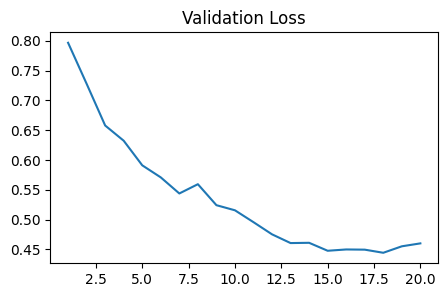

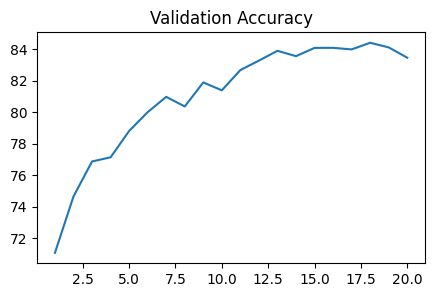

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/Semantic_Segmentation_Postdam/model2_state_save.pth')
epochs = checkpoint['epoch']
accv = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in checkpoint['accv']]
lossv = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in checkpoint['lossv']]

# Plot della validation loss
plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, epochs + 1), lossv)
plt.title('Validation Loss')

# Plot della validation accuracy
plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, epochs + 1), accv)
plt.title('Validation Accuracy')

plt.show()

Test set: Accuracy: 114835799/136750000 (83.97%)


Mean Intersection over Union (mIoU) for each class:
[0.75441118 0.83878605 0.67976749 0.66602701 0.73066915 0.37497753]
Classification report for MLP:
                     precision    recall  f1-score   support

Impervious surfaces       0.86      0.86      0.86  42269619
           Building       0.90      0.92      0.91  34446364
     Low vegetation       0.76      0.86      0.81  30315553
               Tree       0.86      0.75      0.80  20537897
                Car       0.78      0.92      0.84   2312286
 Clutter/background       0.71      0.44      0.55   6868281

           accuracy                           0.84 136750000
          macro avg       0.81      0.79      0.80 136750000
       weighted avg       0.84      0.84      0.84 136750000




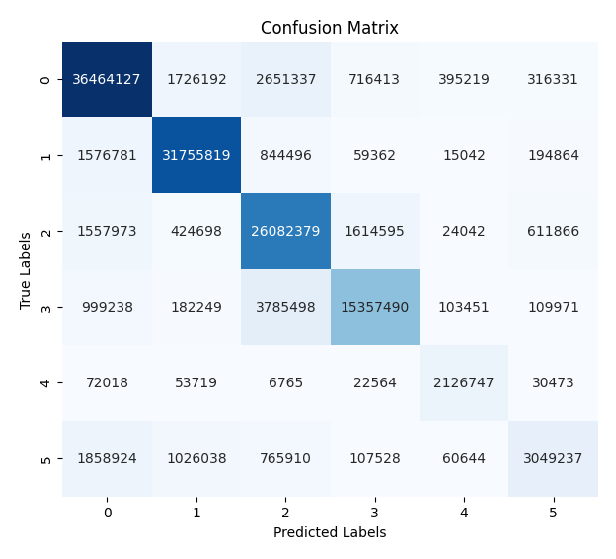

In [ ]:
def compute_mIoU(confusion_matrix):
    intersection = np.diag(confusion_matrix)
    union = np.sum(confusion_matrix, axis=1) + np.sum(confusion_matrix, axis=0) - intersection
    mIoU = intersection / np.maximum(1, union)
    return mIoU

def test():
    model.eval()
    correct = 0
    num_pixels = 0
    predicted_labels = []
    true_labels = []

    for data, target in test_loader:
        data = data.to(device)
        target = target.squeeze(1).to(device)

        output = model(data)
        LogSoftmax = nn.LogSoftmax(dim=1)
        output = LogSoftmax(output)

        pred = torch.argmax(output, axis=1)
        correct += (pred == target).sum()
        num_pixels += torch.numel(pred)

        predicted_labels.extend(pred.cpu().numpy())
        true_labels.extend(target.cpu().numpy())

    accuracy = 100.0 * correct / num_pixels
    print('\nTest set: Accuracy: {}/{} ({:.2f}%)\n'.format(
        correct, num_pixels, accuracy))


    return predicted_labels, true_labels

checkpoint = torch.load('/content/drive/MyDrive/Semantic_Segmentation_Postdam/model2_state_save.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion.load_state_dict(checkpoint['criterion_state_dict'])
epoch = checkpoint['epoch']

predicted_labels, true_labels = test()

predicted_labels = np.array(predicted_labels).flatten()
true_labels = np.array(true_labels).flatten()

# calolo della confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

mIoU_scores = compute_mIoU(confusion_mat)
print("\nMean Intersection over Union (mIoU) for each class:")
print(mIoU_scores)

# Print del classification report
print("Classification report for MLP:\n%s\n"
      % (classification_report(true_labels, predicted_labels, target_names=classes_name)))

plt.figure(figsize=(7, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot di alcune Prediction

In [ ]:
def save_predicted_images_and_labels(test_loader, model, save_dir, num_images=3):
    model.eval()
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    data_iter = iter(test_loader)
    for i in range(num_images):
        data, target = next(data_iter)
        data = data.to(device)
        target = target.squeeze(1).cpu().numpy()

        output = model(data)
        LogSoftmax = nn.LogSoftmax(dim=1)
        output = LogSoftmax(output)
        pred = torch.argmax(output, axis=1).cpu().numpy()

        # Convert predicted and true labels to RGB images for visualization
        predicted_rgb = np.zeros((3, data.shape[2], data.shape[3]), dtype=np.uint8)
        true_rgb = np.zeros((3, data.shape[2], data.shape[3]), dtype=np.uint8)
        for color, class_idx in class_mapping.items():
            mask_pred = pred[0] == class_idx
            mask_true = target[0] == class_idx
            predicted_rgb[0][mask_pred] = color[0]
            predicted_rgb[1][mask_pred] = color[1]
            predicted_rgb[2][mask_pred] = color[2]
            true_rgb[0][mask_true] = color[0]
            true_rgb[1][mask_true] = color[1]
            true_rgb[2][mask_true] = color[2]

        predicted_image_path = os.path.join(save_dir, f"predicted_image_{i}.tif")
        true_image_path = os.path.join(save_dir, f"true_image_{i}.tif")
        Image.fromarray(predicted_rgb.transpose(1, 2, 0)).save(predicted_image_path)
        Image.fromarray(true_rgb.transpose(1, 2, 0)).save(true_image_path)

    print(f"{num_images} predicted images and true label images saved.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_directory = "/content/images_predict"

save_predicted_images_and_labels(test_loader, model, save_directory, num_images=4)


4 predicted images and true label images saved.


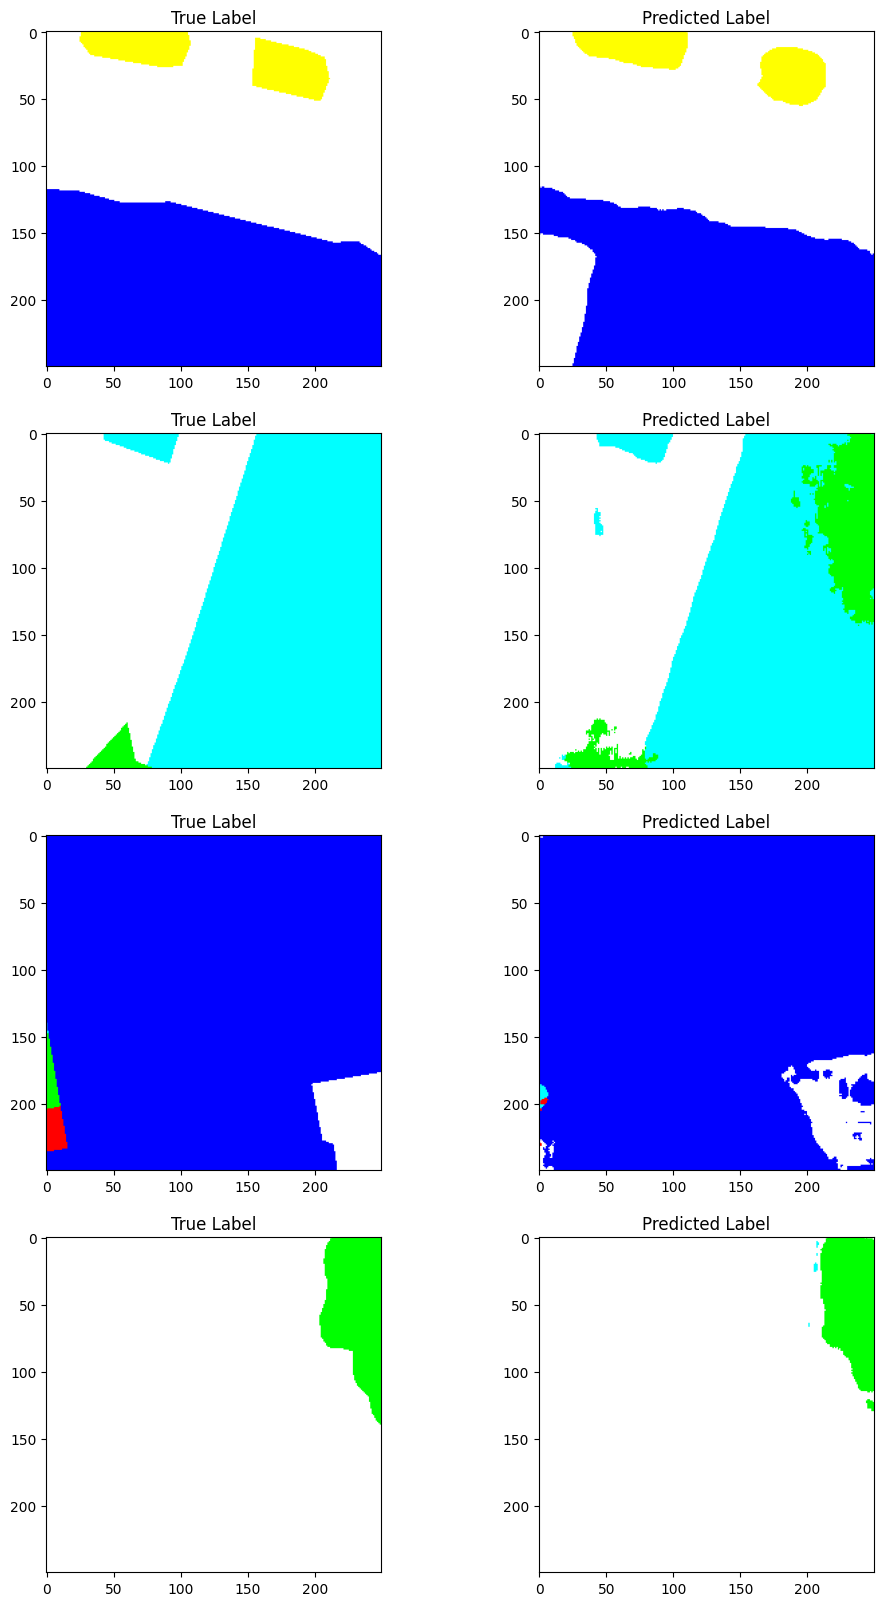

In [ ]:
image_paths = [
    "/content/images_predict/true_image_0.tif",
    "/content/images_predict/predicted_image_0.tif",
    "/content/images_predict/true_image_1.tif",
    "/content/images_predict/predicted_image_1.tif",
    "/content/images_predict/true_image_2.tif",
    "/content/images_predict/predicted_image_2.tif",
    "/content/images_predict/true_image_3.tif",
    "/content/images_predict/predicted_image_3.tif"
]

num_rows = len(image_paths) // 2
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 4 * num_rows))
fig.tight_layout()
plt.subplots_adjust(hspace=0.2)

for i, image_path in enumerate(image_paths):
    row = i // 2
    col = i % 2

    img = mpimg.imread(image_path)
    axes[row, col].imshow(img)
    title = "True Label" if col == 0 else "Predicted Label"
    axes[row, col].set_title(title)
    axes[row, col].axis("on")

plt.show()
